In [1]:
from imports import *
from exactDiagMethods import build_exact_diag_hamiltonian, perform_exact_diag
from globalMethods import  build_initial_states, output_results
from vqteMethods import hamiltonian_generation, perform_vqte

# Don't forget to make F_L, F_R lists
# Make everything work with eps list
# Comment and delete old methods
# Make sure all imports are relevant


In [2]:

def main():
    # Initialize the simulation parameters
    N = 2
    
    gamma_L= 1
    gamma_R = 0.5

    eps = 1
    mu_L= 1
    mu_R= 1

    T_L = 1  
    T_R= 1

    beta_L=1/T_L
    beta_R=1/T_R
    F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
    F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)
    J = 0

    eps_list = []

    for i in range(N):
        eps_list.append(1)

  
    time = 2
    dt = 0.1
    nt = int(time/dt)

 
    # Build hamiltonians
    exact_diag_ham = build_exact_diag_hamiltonian(J, eps_list)

    print("Exact Ham ", exact_diag_ham)
    ham_real, ham_imag = hamiltonian_generation(N, eps_list, gamma_L, gamma_R, F_L, F_R,J)
   
    print("Ham real: ", ham_real)
    print("Ham imag: ", ham_imag)
    # Build initial states
    vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real)
    print("Initil State : " , vqte_init_state)
    print("Exact Initial : ", exact_diag_init_state)

    # Calculate Exact Diag Results
    exact_diag_results = perform_exact_diag(gamma_L,F_L, gamma_R, F_R, dt, nt, exact_diag_init_state,exact_diag_ham, N)

    # Calculate VQTE Results
    vqte_results = perform_vqte(ham_real, ham_imag, vqte_init_state, dt, nt, ansatz, init_param_values,N)
   
   


    # Output results
    output_results(vqte_results, exact_diag_results, time, nt)
    print(vqte_results[0][-1])
    print(exact_diag_results[0][-1])
 
    
    

Exact Ham  [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 2.+0.j]]
Ham real:  SparsePauliOp(['ZIII', 'IZII', 'IIZI', 'IIIZ', 'IXXI', 'IYYI', 'XYII', 'YXII', 'IIXY', 'IIYX'],
              coeffs=[ 0.5+0.j, -0.5+0.j,  0.5+0.j, -0.5+0.j,  0. +0.j,  0. +0.j, -0. +0.j,
 -0. +0.j, -0. +0.j, -0. +0.j])
Ham imag:  SparsePauliOp(['XXII', 'YYII', 'IIXX', 'IIYY', 'IIII', 'ZIII', 'IIIZ'],
              coeffs=[-0.25 +0.j,  0.25 +0.j, -0.125+0.j,  0.125+0.j,  0.75 +0.j, -0.   +0.j,
 -0.   +0.j])
Initil State :  Statevector([ 1.00000000e+00+1.46957616e-15j,
             -1.22464680e-16-1.49975978e-31j,
             -1.22464680e-16-1.49975978e-31j,
             -1.22464680e-16-8.99855870e-32j,
             -2.44929360e-16-2.09966370e-31j,
             -1.22464680e-16-2.99951957e-32j,
             -1.22464680e-16-8.99855870e-32j,
              5.99903913e-32+1.10200561e-47j,
             -3.67394040e-16-3.59942348e-31j,
            

C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


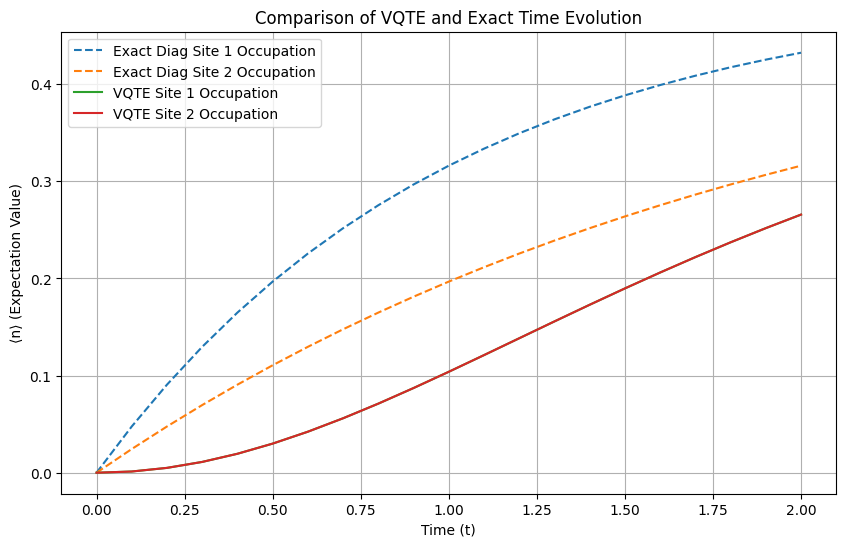

(0.26571251977917276-2.867280882614956e-16j)
0.4323323583816935


In [3]:
main()